- Immuno compromised

- Antibiotics

- Previous HAIs

- Stay Duration

- Other general HAI Features


# Step 0 - Setup & Retrieve data

In [2]:
# Integrates matplotlib with the notebook
%matplotlib inline

# Add all import for libraries will be using
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# plotly imports
# !pip install plotly==5.10.0
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

import warnings
warnings.filterwarnings('ignore')

# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
# Authenticate
auth.authenticate_user()

# define env for running this notebook
# True, if running it locally as a jupyter notebook
# Fase, if running it in Google Colab as a jupyter notebook
is_running_locally = False

# Set up a Jupyter Notebook environment to allow for offline plotting with Plotly
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(is_running_locally)

### Connect MIMIC DB
# Set up environment variables
project_id = 'ml-health-application'   ### Please change project_id
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

### Retrieve HAI patients CSV
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

# Mount data from google drive
# If data stored differently, this path must be changed to match location of the file
drive.mount('/content/gdrive')
file_name = "HAI Positive Patients.csv"
file_path = '/content/gdrive/MyDrive/' + file_name


Mounted at /content/gdrive


In [3]:
# utils
from enum import Enum

class Type(Enum):
    ICDCodes = 1
    ICUStay = 2
    AdmidFirst = 3

def get_patient_query(terms, limit=True):
  join_icd_codes = """INNER JOIN ICDCodes c
  ON c.icd_code = d.icd_code"""
  join_icu_stay = """INNER JOIN ICUStay stay
  ON d.hadm_id = stay.hadm_id and d.subject_id = stay.subject_id"""
  join_admid_first = """INNER JOIN AdmidFirst ad
  ON ad.hadm_id < d.hadm_id"""
  cluases = {
      Type.ICDCodes: join_icd_codes,
      Type.ICUStay: join_icu_stay,
      Type.AdmidFirst: join_admid_first
  }

  base_patient_query = """SELECT *
  FROM `physionet-data.mimiciv_hosp.diagnoses_icd` d
  {}
  INNER JOIN `physionet-data.mimiciv_hosp.admissions` a
    ON d.hadm_id = a.hadm_id
  INNER JOIN `physionet-data.mimiciv_hosp.patients` p
    ON d.subject_id = p.subject_id
  {}"""

  join_cluases = '\n'.join([cluases[term] for term in terms])
  return base_patient_query.format(join_cluases, "LIMIT 1000" if limit else "")

# print(get_patient_query([Type.ICDCodes, Type.ICUStay]))

def generate_sql_with_ctes(cte_dict, main_query):
    """Generate a SQL query with CTEs."""

    # Convert the CTEs into a list of formatted strings
    cte_strings = [f"{name} AS ({query})" for name, query in cte_dict.items()]

    # Join the CTEs with commas and then prepend WITH only once
    ctes_combined = "WITH\n" + ',\n'.join(cte_strings)

    # Combine the formatted CTEs with the main query
    return ctes_combined + '\n' + main_query

def format_icd_codes(icd_codes):
    return str([code.replace('.', '') for code in icd_codes])[1:-1]

def generate_sql_with_icd_codes(icd_codes, limit=True):
    formatted_icd_codes = format_icd_codes(icd_codes)
    icd_diagnose_query = """SELECT *
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd` d
    INNER JOIN `physionet-data.mimiciv_hosp.admissions` a
      ON d.hadm_id = a.hadm_id
    INNER JOIN `physionet-data.mimiciv_hosp.patients` p
      ON d.subject_id = p.subject_id
    WHERE d.icd_code in ({})
    {}"""
    return icd_diagnose_query.format(formatted_icd_codes, "LIMIT 1000" if limit else "")

def generate_sql_with_ctes(cte_dict, main_query):
    """Generate a SQL query with CTEs."""

    # Convert the CTEs into a list of formatted strings
    cte_strings = [f"{name} AS ({query})" for name, query in cte_dict.items()]

    # Join the CTEs with commas and then prepend WITH only once
    ctes_combined = "WITH\n" + ',\n'.join(cte_strings)

    # Combine the formatted CTEs with the main query
    return ctes_combined + '\n' + main_query

def add_like_query(query, terms, label="long_title"):

    # Create the SQL WHERE clause using the list of terms
    where_clauses = [f"lower({label}) LIKE '%{term}%'" for term in terms]
    where_combined = " OR ".join(where_clauses)

    # Combine all parts to generate the final SQL query
    sql_query = f"{query} WHERE {where_combined}"

    return sql_query

### Compromised Immune System

In [131]:
urinary_abnorm_terms = ["obstruction", "urinary retention", "congenital anomaly",
                    "vesicoureteral reflux", "bladder diverticulum"]


# ICD Diagnoses immune-compromising conditions such as Leukemia, HIV and Diabetes
# Patients with conditions like HIV, diabetes, or those receiving immunosuppressants are more susceptible to infections, including CAUTIs
immune_compromised_cte  = {}


immune_compromised_terms = [
    "hiv", "aids", "diabetes", "organ transplant", "leukemia", "lymphoma",
    "cancer", "chronic kidney disease", "end-stage renal disease", "splenectomy",
    "bone marrow transplant", "malnutrition", "congenital immune deficiencies"
]

immune_compromised_diagnoses = add_like_query("SELECT icd_code, long_title FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`", immune_compromised_terms)

immune_compromised_cte["ICDCodes"] = immune_compromised_diagnoses

immune_compromised_patients_sql = generate_sql_with_ctes(immune_compromised_cte, get_patient_query([Type.ICDCodes]))
immune_compromised_patients = run_query(immune_compromised_patients_sql)
immune_compromised_patients

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code_1,long_title,subject_id_1,hadm_id_1,admittime,...,race,edregtime,edouttime,hospital_expire_flag,subject_id_2,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10003400,20214994,30,40390,9,40390,"Hypertensive chronic kidney disease, unspecifi...",10003400,20214994,2137-02-24 10:00:00,...,BLACK/AFRICAN AMERICAN,NaT,NaT,0,10003400,F,72,2134,2011 - 2013,2137-09-02
1,10024331,25768667,26,28521,9,28521,Anemia in chronic kidney disease,10024331,25768667,2144-09-07 15:17:00,...,WHITE - RUSSIAN,NaT,NaT,0,10024331,M,72,2140,2008 - 2010,2145-01-23
2,10031358,24522342,33,25072,9,25072,Diabetes with peripheral circulatory disorders...,10031358,24522342,2158-03-10 18:06:00,...,WHITE,2158-03-10 13:12:00,2158-03-10 19:51:00,0,10031358,M,58,2152,2008 - 2010,NaT
3,10031358,24522342,35,40390,9,40390,"Hypertensive chronic kidney disease, unspecifi...",10031358,24522342,2158-03-10 18:06:00,...,WHITE,2158-03-10 13:12:00,2158-03-10 19:51:00,0,10031358,M,58,2152,2008 - 2010,NaT
4,10031358,24522342,36,5859,9,5859,"Chronic kidney disease, unspecified",10031358,24522342,2158-03-10 18:06:00,...,WHITE,2158-03-10 13:12:00,2158-03-10 19:51:00,0,10031358,M,58,2152,2008 - 2010,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,16021373,23184382,30,25050,9,25050,"Diabetes with ophthalmic manifestations, type ...",16021373,23184382,2187-10-30 08:00:00,...,WHITE,NaT,NaT,0,16021373,F,72,2187,2014 - 2016,NaT
996,16032226,20056878,29,25062,9,25062,"Diabetes with neurological manifestations, typ...",16032226,20056878,2185-07-01 19:04:00,...,WHITE,2185-07-01 15:21:00,2185-07-01 20:48:00,0,16032226,M,73,2182,2008 - 2010,2185-10-07
997,16032226,20056878,30,40310,9,40310,"Hypertensive chronic kidney disease, benign, w...",16032226,20056878,2185-07-01 19:04:00,...,WHITE,2185-07-01 15:21:00,2185-07-01 20:48:00,0,16032226,M,73,2182,2008 - 2010,2185-10-07
998,16043614,26710319,26,25003,9,25003,Diabetes mellitus without mention of complicat...,16043614,26710319,2188-04-29 12:59:00,...,WHITE,2188-04-29 10:04:00,2188-04-29 15:40:00,0,16043614,M,49,2182,2008 - 2010,2188-07-22


### Antibiotics

list of some commonly used immunosuppressant drugs that could potentially increase the risk of HAIs:

1.Corticosteroids: These are a class of drugs that include:

* Prednisone
* Methylprednisolone (Medrol)
* Hydrocortisone
* Dexamethasone
2.Calcineurin Inhibitors: These drugs block the action of calcineurin, which plays a role in the activation of T cells.

* Cyclosporine (Neoral, Sandimmune, Gengraf)
* Tacrolimus (Prograf)

3.mTOR Inhibitors (Mammalian Target of Rapamycin): These drugs block the action of mTOR, a protein involved in cell multiplication.

* Sirolimus (Rapamune)
* Everolimus (Zortress)
4.Antiproliferative/Antimetabolite Agents: These prevent the synthesis of DNA and thus prevent the proliferation of cells.

* Mycophenolate mofetil (CellCept)
* Mycophenolate sodium (Myfortic)
* Azathioprine (Imuran, Azasan)
* Methotrexate
5. Biologic Agents: These are antibodies or related proteins that target specific parts of the immune system.

* Infliximab (Remicade)
* Adalimumab (Humira)
* Rituximab (Rituxan, MabThera)
* Abatacept (Orencia)
* Etanercept (Enbrel)
* Ustekinumab (Stelara)
6. Antithymocyte Globulin (ATG):

* Thymoglobulin
* Atgam
7.Other Agents:

* Cyclophosphamide
* Chlorambucil


In [85]:
# patients received immunosuppressive prescriptions
immunosuppressive_prescriptions = [
    "prednisone" ,"methylprednisolone" ,"hydrocortisone" ,"dexamethasone" ,"cyclosporine" ,"tacrolimus" ,"sirolimus" ,"everolimus" ,
    "mycophenolate mofetil" ,"mycophenolate sodium" ,"azathioprine" ,"methotrexate" ,"infliximab" ,"adalimumab" ,"rituximab" ,
    "abatacept" ,"etanercept" ,"ustekinumab" ,"thymoglobulin" ,"atgam" ,"cyclophosphamide" ,"chlorambucil"
]

precriptions_query = "SELECT DISTINCT subject_id, hadm_id, drug FROM `physionet-data.mimiciv_hosp.prescriptions`"
immunosuppressive_prescription_patients = add_like_query(precriptions_query, immunosuppressive_prescriptions, "drug")
patient_immunosuppressant_drugs = run_query(immunosuppressive_prescription_patients)
patient_immunosuppressant_drugs

,subject_id,hadm_id,drug
0,12902507,28019095,PredniSONE
1,10685894,23518555,Tacrolimus
2,11882807,28524734,Tacrolimus
3,11971615,21517781,Tacrolimus
4,13818168,25178055,Tacrolimus
...,...,...,...
108387,19848401,20012521,Hydrocortisone (Rectal) 2.5% Cream
108388,15600650,20012858,Hydrocortisone (Rectal) 2.5% Cream
108389,10156269,25904914,Cyclophosphamide
108390,16417863,29748293,Methotrexate


### HAI Patients

In [132]:
hai_patients_csv = pd.read_csv(file_path)
hai_patients_csv

,subject_id,hadm_id,stay_id,icd_code,long_title,HAI_Type
0,10007818,22987108,32359580.0,T80219A,Unspecified infection due to central venous ca...,CLABSI
1,10785126,20598872,39785361.0,T80211D,Bloodstream infection due to central venous ca...,CLABSI
2,10207354,24602624,NaN,T80219A,Unspecified infection due to central venous ca...,CLABSI
3,11624559,29387474,NaN,T80218A,Other infection due to central venous catheter...,CLABSI
4,11864591,27843066,NaN,T83510A,Infection and inflammatory reaction due to cys...,CAUTI
...,...,...,...,...,...,...
5564,13766350,26137394,30935196.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5565,12200502,29234722,32185728.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5566,12200502,29234722,39773284.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5567,11708854,20452061,NaN,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI


In [133]:
hai_icd_codes = hai_patients_csv['icd_code'].unique()
hai_icd_diagnoses = "SELECT icd_code, long_title FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses` where icd_code in ({})".format(format_icd_codes(hai_icd_codes))
# get patients with HAIs ICDCodes
hai_patients = run_query(generate_sql_with_icd_codes(hai_icd_codes))

### Stay Duration

In [134]:
# icu stay for immune_compromised_patient
icu_stay_query = "SELECT subject_id, hadm_id, los FROM `physionet-data.mimiciv_icu.icustays`"
patients_with_los_cte = {}
patients_with_los_cte["ICUStay"] = icu_stay_query
patients_with_los_cte["ICDCodes"] = immune_compromised_diagnoses

patients_with_immune_compromised_los_sql = generate_sql_with_ctes(patients_with_los_cte, get_patient_query([Type.ICUStay, Type.ICDCodes]))
patients_with_immune_compromised_los = run_query(patients_with_immune_compromised_los_sql)
patients_with_immune_compromised_los

,subject_id,hadm_id,seq_num,icd_code,icd_version,subject_id_1,hadm_id_1,los,icd_code_1,long_title,...,race,edregtime,edouttime,hospital_expire_flag,subject_id_3,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10003400,20214994,30,40390,9,10003400,20214994,12.911308,40390,"Hypertensive chronic kidney disease, unspecifi...",...,BLACK/AFRICAN AMERICAN,NaT,NaT,0,10003400,F,72,2134,2011 - 2013,2137-09-02
1,10035168,26166196,31,V180,9,10035168,26166196,8.809178,V180,Family history of diabetes mellitus,...,WHITE,NaT,NaT,1,10035168,F,56,2144,2008 - 2010,2147-01-07
2,10038081,20755971,29,5859,9,10038081,20755971,3.698519,5859,"Chronic kidney disease, unspecified",...,UNKNOWN,NaT,NaT,1,10038081,F,63,2115,2014 - 2016,2115-10-12
3,10038081,20755971,30,40390,9,10038081,20755971,3.698519,40390,"Hypertensive chronic kidney disease, unspecifi...",...,UNKNOWN,NaT,NaT,1,10038081,F,63,2115,2014 - 2016,2115-10-12
4,10098215,22394571,32,5859,9,10098215,22394571,12.797535,5859,"Chronic kidney disease, unspecified",...,WHITE,2118-05-03 15:58:00,2118-05-04 02:25:00,0,10098215,F,56,2117,2008 - 2010,2118-09-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,16662264,26390489,26,25083,9,16662264,26390489,8.355405,25083,"Diabetes with other specified manifestations, ...",...,WHITE,2138-07-03 18:18:00,2138-07-03 20:52:00,0,16662264,F,47,2133,2008 - 2010,2139-07-14
996,16686303,22817956,26,25000,9,16686303,22817956,6.385868,25000,Diabetes mellitus without mention of complicat...,...,WHITE,2176-12-05 16:13:00,2176-12-05 23:25:00,0,16686303,F,76,2175,2011 - 2013,2177-05-13
997,16686303,22817956,26,25000,9,16686303,22817956,3.131898,25000,Diabetes mellitus without mention of complicat...,...,WHITE,2176-12-05 16:13:00,2176-12-05 23:25:00,0,16686303,F,76,2175,2011 - 2013,2177-05-13
998,16690709,22616266,28,28521,9,16690709,22616266,1.270613,28521,Anemia in chronic kidney disease,...,WHITE,2177-02-08 20:23:00,2177-02-09 01:00:00,0,16690709,M,79,2175,2008 - 2010,NaT


In [135]:
# icu stay for HAI patients
icu_stay_query = "SELECT subject_id, hadm_id, los FROM `physionet-data.mimiciv_icu.icustays`"
patients_with_los_cte = {}
patients_with_los_cte["ICUStay"] = icu_stay_query
patients_with_los_cte["ICDCodes"] = hai_icd_diagnoses

patients_with_los = generate_sql_with_ctes(patients_with_los_cte, get_patient_query([Type.ICUStay, Type.ICDCodes]))
patients_with_hai_los = run_query(patients_with_los)
patients_with_hai_los

,subject_id,hadm_id,seq_num,icd_code,icd_version,subject_id_1,hadm_id_1,los,icd_code_1,long_title,...,race,edregtime,edouttime,hospital_expire_flag,subject_id_3,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10723086,20456851,28,99932,9,10723086,20456851,54.843808,99932,Bloodstream infection due to central venous ca...,...,BLACK/AFRICAN,2191-09-14 23:43:00,2191-09-16 01:20:00,0,10723086,F,41,2185,2008 - 2010,2193-02-12
1,10723086,20456851,28,99932,9,10723086,20456851,5.748646,99932,Bloodstream infection due to central venous ca...,...,BLACK/AFRICAN,2191-09-14 23:43:00,2191-09-16 01:20:00,0,10723086,F,41,2185,2008 - 2010,2193-02-12
2,10947245,24307798,27,99931,9,10947245,24307798,25.729398,99931,Other and unspecified infection due to central...,...,WHITE,NaT,NaT,0,10947245,F,43,2135,2008 - 2010,NaT
3,10947245,24307798,27,99931,9,10947245,24307798,5.924722,99931,Other and unspecified infection due to central...,...,WHITE,NaT,NaT,0,10947245,F,43,2135,2008 - 2010,NaT
4,10947245,24307798,27,99931,9,10947245,24307798,3.956701,99931,Other and unspecified infection due to central...,...,WHITE,NaT,NaT,0,10947245,F,43,2135,2008 - 2010,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15026237,27572035,4,T83511A,10,15026237,27572035,2.718333,T83511A,Infection and inflammatory reaction due to ind...,...,WHITE,2134-09-12 14:00:00,2134-09-13 04:03:00,0,15026237,M,67,2126,2008 - 2010,2134-11-09
996,15152579,26248295,4,J95851,10,15152579,26248295,16.862002,J95851,Ventilator associated pneumonia,...,WHITE - OTHER EUROPEAN,2196-11-14 09:31:00,2196-11-14 18:09:00,1,15152579,M,91,2191,2011 - 2013,2196-12-02
997,15221002,28147550,4,J95851,10,15221002,28147550,15.598669,J95851,Ventilator associated pneumonia,...,UNKNOWN,2133-06-26 15:42:00,2133-06-27 01:33:00,0,15221002,M,57,2133,2017 - 2019,NaT
998,15452777,23098609,4,T80211A,10,15452777,23098609,7.912870,T80211A,Bloodstream infection due to central venous ca...,...,WHITE,NaT,NaT,1,15452777,M,67,2157,2017 - 2019,2158-03-26


# Step 1 - Data Preprocessing


## Select only interested fields

In [136]:
immune_compromised_patients = immune_compromised_patients[['subject_id', 'hadm_id', 'icd_code', 'race', 'gender', 'anchor_age', 'dod']]
patients_with_immune_compromised_los = patients_with_immune_compromised_los[['subject_id', 'hadm_id', 'icd_code', 'race', 'gender', 'anchor_age', 'dod', 'los']]
patients_with_hai_los = patients_with_hai_los[['subject_id', 'hadm_id', 'icd_code', 'race', 'gender', 'anchor_age', 'dod', 'los']]

## Check for missing values

In [94]:
print("hai_patients")
print(hai_patients_csv.isnull().sum())
print("total:", hai_patients_csv.shape[0])

print("\nimmune_compromised_patients")
print(immune_compromised_patients.isnull().sum())
print("total:", immune_compromised_patients.shape[0])

print("\npatient_immunosuppressant_drugs")
print(patient_immunosuppressant_drugs.isnull().sum())
print("total:", patient_immunosuppressant_drugs.shape[0])

print("\npatients_with_immune_compromised_los")
print(patients_with_immune_compromised_los.isnull().sum())
print("total:", patients_with_immune_compromised_los.shape[0])

# derived based on the icd codes from csv file
print("\npatients_with_hai_los")
print(patients_with_hai_los.isnull().sum())
print("total:", patients_with_hai_los.shape[0])

hai_patients
subject_id       0
hadm_id          0
stay_id       2154
icd_code         0
long_title       0
HAI_Type         0
dtype: int64
total: 5569

immune_compromised_patients
subject_id      0
hadm_id         0
icd_code        0
race            0
gender          0
anchor_age      0
dod           301
dtype: int64
total: 1000

patient_immunosuppressant_drugs
subject_id    0
hadm_id       0
drug          0
dtype: int64
total: 108392

patients_with_immune_compromised_los
subject_id      0
hadm_id         0
icd_code        0
race            0
gender          0
anchor_age      0
dod           264
los             0
dtype: int64
total: 1000

patients_with_hai_los
subject_id      0
hadm_id         0
icd_code        0
race            0
gender          0
anchor_age      0
dod           452
los             0
dtype: int64
total: 1000


## Preview

In [95]:
hai_patients_csv.head()

,subject_id,hadm_id,stay_id,icd_code,long_title,HAI_Type
0,10007818,22987108,32359580.0,T80219A,Unspecified infection due to central venous ca...,CLABSI
1,10785126,20598872,39785361.0,T80211D,Bloodstream infection due to central venous ca...,CLABSI
2,10207354,24602624,NaN,T80219A,Unspecified infection due to central venous ca...,CLABSI
3,11624559,29387474,NaN,T80218A,Other infection due to central venous catheter...,CLABSI
4,11864591,27843066,NaN,T83510A,Infection and inflammatory reaction due to cys...,CAUTI


In [96]:
immune_compromised_patients.head()

,subject_id,hadm_id,icd_code,race,gender,anchor_age,dod
0,10003400,20214994,40390,BLACK/AFRICAN AMERICAN,F,72,2137-09-02
1,10024331,25768667,28521,WHITE - RUSSIAN,M,72,2145-01-23
2,10031358,24522342,25072,WHITE,M,58,NaT
3,10031358,24522342,40390,WHITE,M,58,NaT
4,10031358,24522342,5859,WHITE,M,58,NaT


In [97]:
patient_immunosuppressant_drugs.head()

,subject_id,hadm_id,drug
0,12902507,28019095,PredniSONE
1,10685894,23518555,Tacrolimus
2,11882807,28524734,Tacrolimus
3,11971615,21517781,Tacrolimus
4,13818168,25178055,Tacrolimus


In [98]:
patients_with_immune_compromised_los.head()

,subject_id,hadm_id,icd_code,race,gender,anchor_age,dod,los
0,10003400,20214994,40390,BLACK/AFRICAN AMERICAN,F,72,2137-09-02,12.911308
1,10035168,26166196,V180,WHITE,F,56,2147-01-07,8.809178
2,10038081,20755971,5859,UNKNOWN,F,63,2115-10-12,3.698519
3,10038081,20755971,40390,UNKNOWN,F,63,2115-10-12,3.698519
4,10098215,22394571,5859,WHITE,F,56,2118-09-19,12.797535


## Convert categorical to numberical format
`survived` is 1 if `dod` is not existed, 0 otherwise
`gender_num` is 1 if `gender`='M', 0 if gender='F'

In [137]:
race_mapping = {
    'BLACK/AFRICAN AMERICAN': 0,
    'WHITE - RUSSIAN': 1,
    'WHITE': 2,
    'UNKNOWN': 3,
    'OTHER': 4,
    'HISPANIC OR LATINO': 5,
    'HISPANIC/LATINO - CENTRAL AMERICAN': 6,
    'WHITE - OTHER EUROPEAN': 7,
    'PORTUGUESE': 8,
    'UNABLE TO OBTAIN': 9,
    'HISPANIC/LATINO - HONDURAN': 10,
    'BLACK/CARIBBEAN ISLAND': 11,
    'HISPANIC/LATINO - PUERTO RICAN': 12,
    'ASIAN': 13,
    'ASIAN - CHINESE': 14,
    'BLACK/AFRICAN': 15,
    'HISPANIC/LATINO - DOMINICAN': 16,
    'AMERICAN INDIAN/ALASKA NATIVE': 17,
    'SOUTH AMERICAN': 18,
    'PATIENT DECLINED TO ANSWER': 19,
    'ASIAN - SOUTH EAST ASIAN': 20,
    'MULTIPLE RACE/ETHNICITY': 21,
    'BLACK/CAPE VERDEAN': 22,
    'ASIAN - ASIAN INDIAN': 23
}


def convert_to_numerical_values(df):
  # convert to numerical values
  df['survived'] = pd.to_datetime(df['dod'], errors='coerce').isna()
  df['gender_num'] = df['gender'].map({'F': 0, 'M': 1})
  df['race'] = df['race'].map(race_mapping)

  # round up LOS
  if 'los' in df.columns:
    df['los'] = df['los'].round(0).astype(int)

  # drop unused field
  df = df.drop(['dod', 'gender'], axis = 1)

  return df.round()

immune_compromised_patients = convert_to_numerical_values(immune_compromised_patients)
patients_with_immune_compromised_los = convert_to_numerical_values(patients_with_immune_compromised_los)
patients_with_hai_los = convert_to_numerical_values(patients_with_hai_los)

In [138]:
immune_compromised_patients.head()

,subject_id,hadm_id,icd_code,race,anchor_age,survived,gender_num
0,10003400,20214994,40390,0,72,False,0
1,10024331,25768667,28521,1,72,False,1
2,10031358,24522342,25072,2,58,True,1
3,10031358,24522342,40390,2,58,True,1
4,10031358,24522342,5859,2,58,True,1


In [139]:
patients_with_immune_compromised_los.head()

,subject_id,hadm_id,icd_code,race,anchor_age,los,survived,gender_num
0,10003400,20214994,40390,0,72,13,False,0
1,10035168,26166196,V180,2,56,9,False,0
2,10038081,20755971,5859,3,63,4,False,0
3,10038081,20755971,40390,3,63,4,False,0
4,10098215,22394571,5859,2,56,13,False,0


# Step 2 - Feature Engineering
Feature Engineering: Create new features based on existing ones to improve model performance.

E.g. calculate infection rates within the first 48 hours of hospital admission.


# Step 3 - Exploratory Data Analysis (EDA)

Statistical Analysis: Descriptive statistics, correlations, etc.

Data Visualisation: Graphical representation of data distribution, relationships, etc.

Feature Importance Analysis: Identify which features are likely to have the most impact on the model. (Preliminary Tree Based Models)

## Relation between ICD and each HAI Type

In [210]:
# Total unique patients
print("Total HAI patients:", len(hai_patients_csv.drop_duplicates(subset=['subject_id'])))
print("Total Immune Compromised Patients patients:", len(immune_compromised_patients.drop_duplicates(subset=['subject_id'])))

Total HAI patients: 3871
Total Immune Compromised Patients patients: 615


In [202]:
# Matched immune_compromised_patients with HAI patient
matching_immune_compromised_and_hai_patients = set(hai_patients_csv['subject_id']).intersection(immune_compromised_patients['subject_id'])
len(matching_immune_compromised_and_hai_patients)

141

In [ ]:
# combined icd

In [196]:
unique_icd_immune_compromised = np.array(immune_compromised_patients['icd_code'].unique())

# Pivot the DataFrame to get the desired format
df = pd.DataFrame(immune_compromised_patients)
pivot_df = df.pivot_table(index=['subject_id'],
                            columns='icd_code',
                            aggfunc='size',
                            fill_value=0).reset_index()
# Create custom column names with 'icd_' prefix
custom_column_names = ['icd_' + code for code in unique_icd_immune_compromised]

# Reset the index to match your desired output
pivot_df.columns.name = None
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.rename(columns=dict(zip(unique_icd_immune_compromised, custom_column_names)))
pivot_df

,index,subject_id,icd_20780,icd_24900,icd_24981,icd_25000,icd_25001,icd_25002,icd_25003,icd_25020,...,icd_40391,icd_5852,icd_5853,icd_5854,icd_5859,icd_V08,icd_V1060,icd_V166,icd_V180,icd_V4983
0,0,10003400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10024331,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,10031358,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,10031687,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,10035168,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,610,16013042,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
611,611,16015242,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
612,612,16021373,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
613,613,16032226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
# Pivot the DataFrame to get the desired format
df2 = pd.DataFrame(hai_patients_csv)
pivot_df2 = df2.pivot_table(index=['subject_id'],
                            columns='HAI_Type',
                            aggfunc='size',
                            fill_value=0).reset_index()
# Create custom column names with 'icd_' prefix
custom_column_names = ['type_' + code for code in hai_patients_csv['HAI_Type'].unique()]

# Reset the index to match your desired output
pivot_df2.columns.name = None
pivot_df2 = pivot_df2.reset_index()
pivot_df2 = pivot_df2.rename(columns=dict(zip(hai_patients_csv['HAI_Type'].unique(), custom_column_names)))
pivot_df2

,index,subject_id,type_CAUTI,type_CLABSI,type_VAP
0,0,10004322,1,0,0
1,1,10004733,0,0,1
2,2,10007818,0,1,1
3,3,10009614,0,1,0
4,4,10010440,1,0,0
...,...,...,...,...,...
3866,3866,19985545,0,1,0
3867,3867,19986810,1,0,0
3868,3868,19995595,0,1,1
3869,3869,19997367,0,1,1


In [233]:
merged_df = pd.merge(pivot_df, pivot_df2, on='subject_id', how='inner')
type_columns = merged_df.filter(like='type_')

# if value in each icd_xx or type_xx > 1, set it to 1
merged_df[merged_df.filter(like='type_') > 1] = 1
merged_df[merged_df.filter(like='icd_') > 1] = 1

merged_df

,index_x,subject_id,icd_20780,icd_24900,icd_24981,icd_25000,icd_25001,icd_25002,icd_25003,icd_25020,...,icd_5859,icd_V08,icd_V1060,icd_V166,icd_V180,icd_V4983,index_y,type_CAUTI,type_CLABSI,type_VAP
0,7,10039348,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,1,0
1,8,10098215,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,34,0,1,0
2,11,10123949,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,45,0,1,0
3,20,10213275,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,70,0,1,0
4,22,10244884,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,82,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,602,15942934,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2348,1,1,0
137,603,15945590,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2350,0,1,0
138,610,16013042,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2376,1,0,0
139,613,16032226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2383,0,1,0


In [234]:
type_columns = merged_df.filter(like='type_')
icd_columns = merged_df.filter(like='icd_')

# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Create a dictionary to store the most related 'icd_' column for each 'type_'
most_related_icd = {}

# Iterate through 'type_' columns and find the most related 'icd_' column
for type_column in type_columns.columns:
    correlations = correlation_matrix[type_column].loc[icd_columns.columns]
    most_related_icd[type_column] = correlations.idxmax()

# Print the most related 'icd_' columns for each 'type_'
for type_column, icd_column in most_related_icd.items():
    print(f"'{type_column}' is most related to '{icd_column}' with a correlation of {correlation_matrix[type_column][icd_column]}")

'type_CAUTI' is most related to 'icd_25060' with a correlation of 0.24555715830390185
'type_CLABSI' is most related to 'icd_28521' with a correlation of 0.16680697361410543
'type_VAP' is most related to 'icd_25000' with a correlation of 0.24247992772540486


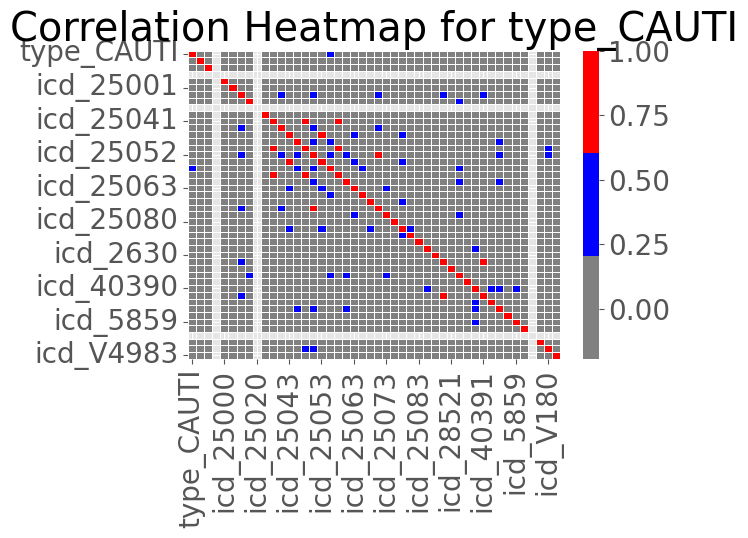

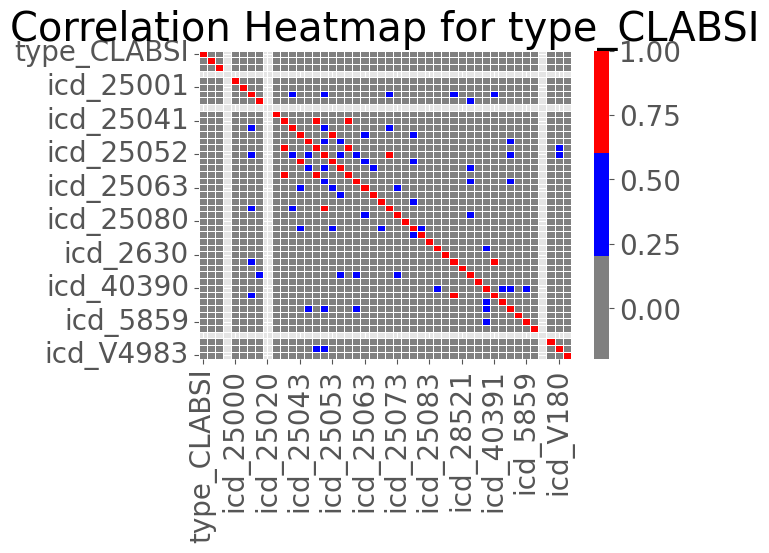

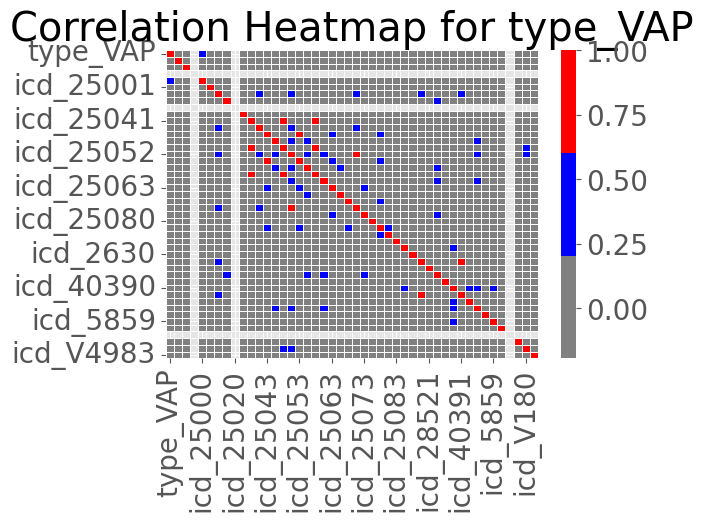

In [239]:
type_columns = merged_df.filter(like='type_')

# Create individual correlation heatmaps for each 'type_' column
for type_column in type_columns.columns:
    plt.figure(figsize=(6, 4))
    correlation_matrix = merged_df[[type_column] + list(merged_df.columns[merged_df.columns.str.startswith('icd_')])].corr()
    # print(correlation_matrix)
    cmap = sns.color_palette(['grey', 'blue', 'red'])
    sns.heatmap(correlation_matrix, annot=False, cmap=cmap, linewidths=0.5)
    plt.title(f'Correlation Heatmap for {type_column}')
    plt.show()

## Related Antibiotics

In [244]:
# pick antibiotic records from immuned compromised patient but not HAI
# patient_immunosuppressant_drugs hai_patients_csv immune_compromised_patients
result_df = patient_immunosuppressant_drugs.merge(immune_compromised_patients, on=['subject_id', 'hadm_id'], how='inner')
result_df = result_df.merge(hai_patients_csv, on=['subject_id', 'hadm_id'], how='inner')
result_df

,subject_id,hadm_id,drug,icd_code_x,race,anchor_age,survived,gender_num,stay_id,icd_code_y,long_title,HAI_Type
0,13780860,24874195,PredniSONE,28521,0,47,False,0,35163941.0,99931,Other and unspecified infection due to central...,CLABSI
1,13780860,24874195,PredniSONE,28521,0,47,False,0,36084276.0,99931,Other and unspecified infection due to central...,CLABSI
2,13780860,24874195,Hydrocortisone Na Succ.,28521,0,47,False,0,35163941.0,99931,Other and unspecified infection due to central...,CLABSI
3,13780860,24874195,Hydrocortisone Na Succ.,28521,0,47,False,0,36084276.0,99931,Other and unspecified infection due to central...,CLABSI
4,15259244,21934455,Sirolimus,25051,23,57,False,0,34881701.0,99731,Ventilator associated pneumonia,VAP
...,...,...,...,...,...,...,...,...,...,...,...,...
304,10526776,29693819,Dexamethasone,3572,0,65,False,1,35896638.0,99731,Ventilator associated pneumonia,VAP
305,10526776,29693819,Dexamethasone,3572,0,65,False,1,32588322.0,99731,Ventilator associated pneumonia,VAP
306,13818699,23683892,Hydrocortisone Na Succ.,25000,7,46,True,0,34519213.0,99731,Ventilator associated pneumonia,VAP
307,13994398,28591150,Hydrocortisone Oint 0.5%,40390,3,67,True,1,31167267.0,99731,Ventilator associated pneumonia,VAP


In [247]:
result_df.columns

Index(['subject_id', 'hadm_id', 'drug', 'icd_code_x', 'race', 'anchor_age',
       'survived', 'gender_num', 'stay_id', 'icd_code_y', 'long_title',
       'HAI_Type'],
      dtype='object')

In [249]:
distinct_records_df = result_df[['subject_id', 'hadm_id', 'drug', 'icd_code_x', 'HAI_Type']]
distinct_records_df = distinct_records_df.drop_duplicates()
distinct_records_df

,subject_id,hadm_id,drug,icd_code_x,HAI_Type
0,13780860,24874195,PredniSONE,28521,CLABSI
2,13780860,24874195,Hydrocortisone Na Succ.,28521,CLABSI
4,15259244,21934455,Sirolimus,25051,VAP
5,15259244,21934455,Tacrolimus,25051,VAP
6,15259244,21934455,Dexamethasone,25051,VAP
...,...,...,...,...,...
300,10526776,29693819,Dexamethasone,3572,CAUTI
303,10526776,29693819,Dexamethasone,3572,VAP
306,13818699,23683892,Hydrocortisone Na Succ.,25000,VAP
307,13994398,28591150,Hydrocortisone Oint 0.5%,40390,VAP


# Note